## Initial Processing of Gravity Data

In [1]:
#Import required packages - 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import *
import pandas as pd
import pyproj
import sys
sys.path.insert(0,'Required_packages')
from tidegravity import *
from scipy.interpolate import LinearNDInterpolator

### Read in the data
We define a function to read in the text file that is output by the gravity meter and then take the columns we want and put them in a pandas dataframe.

In [2]:
#This is a function to read in the text tile that is output but the gravity meter 
#- you don't need to understand exactly what it does but it basically reads the the file line by line and extracts certain bits for different data columns
linen=[]
station=[] 
alt=[]
grav=[]  
sd=[]
tiltx=[]
tilty=[]
temp=[]
etc=[]
dur=[]
rej=[]
t=[]
ts = []
corr_g=[]
keepdata=[]
epoch = []
keepitem=int
def readRawDataFile(filename):  
        """ read a raw ascii data text file extracted from CG5
     
        sometimes bad values are written by the CG5 soft, if such case happen,
        an error is raised and the user is asked for checking the data file 
        manually
        """    
   
        try:
            #essaye d'ouvrir le fichier
            fh = open(filename, 'r')
            i=0
            #PBAR = ProgressBar(total=len([1 for line in  open(filename, 'r')]),textmess='Load raw data')   
            #print "number of lines: %d"%len([1 for line in  open(filename, 'r')])
            #PBAR.show()
            for line in fh:    
                #PBAR.progressbar.setValue(i)
                i+=1
                # Clean line
                line = line.strip()
                # Skip blank and comment lines
                if (not line) or (line[0] == '/') or (line[0] == 'L'): continue
        	     #parse string line first with respect to '/' caracters (used in the date format), 
        	     #then with ':' (used for the time display), eventually with the classic ' '
                vals_temp1=line.split('/')
                vals_temp2=vals_temp1[0].split(':')
                vals_temp3=vals_temp2[0].split()                
                vals_temp4=vals_temp2[2].split()

                # fill object properties:
                linen.append(float(vals_temp3[0]))
                station.append(float(vals_temp3[1]))
                alt.append(float(vals_temp3[2]))
                grav.append(float(vals_temp3[3]))
                sd.append(float(vals_temp3[4]))
                tiltx.append(float(vals_temp3[5]))
                tilty.append(float(vals_temp3[6]))
                temp.append(float(vals_temp3[7]))
                etc.append(float(vals_temp3[8]))
                dur.append(int(vals_temp3[9]))
                rej.append(int(vals_temp3[10]))
                t.append(datetime(int(vals_temp4[3]),int(vals_temp1[1]),\
                int(vals_temp1[2]),int(vals_temp3[11]),int(vals_temp2[1]),\
                int(vals_temp4[0])))       
                t_tmp = '%04d-%02d-%02dT%02d:%02d:%02d'%\
                    (int(vals_temp4[3]),int(vals_temp1[1]),\
                    int(vals_temp1[2]),int(vals_temp3[11]),int(vals_temp2[1]),\
                    int(vals_temp4[0]))  
                ts.append(pd.Timestamp(t_tmp))
                epoch.append((pd.Timestamp(t_tmp) - pd.Timestamp("1970-01-01")).total_seconds())

                keepdata.append(1)                                                                                         
        except IOError:
            #si ça ne marche pas, affiche ce message et continue le prog
            print ('No file : %s' %(filename))            
        except ValueError:
            print ('pb at line %d : check raw data file'%(i))
        except IndexError:
            print ('pb at line %d : check raw data file: possibly last line?'%(i) )

In [3]:
#read in gravity data
readRawDataFile('Data/grav_all_data.TXT') #since we have defined the function readRawDataFile in the above cell we can just call it here with our file name
#note that if you run this multiple times it will keep adding onto the bottom of the lists - so you'll end up multiple copys of the data in your dataframe

scintrex_data = pd.DataFrame({'grav':grav,'sta':station, 'timestamp':ts, 'sd':sd, 'tiltx':tiltx, 'tilty':tilty, 'temp':temp}) #here we define our pandas dataframe with the data columns we are interested in


### Read in and assign gps data

Our gps data is stored seperately so we also want to read that in and assign the correct positions and elevations to the stations by name.

In [4]:
#read in gps data
stations_gps = pd.read_csv('Data/GPS/grav_all_ppk_stations.csv', usecols=[0,3,4,5,6],skiprows=1,names=['Name', 'Elev_std', 'x_8N', 'y_8N', 'Elevation'])
#create columns with value -999 that we will overwrite with the correct value
scintrex_data['x_8N'] = -999
scintrex_data['y_8N'] = -999
scintrex_data['Elev'] = -999
scintrex_data['Elev_std'] = -999
for i in range(len(stations_gps)): #loop through all the stations in the gps data
    scintrex_data['x_8N'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['x_8N'].iloc[i]
    scintrex_data['y_8N'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['y_8N'].iloc[i]
    scintrex_data['Elev'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['Elevation'].iloc[i]
    scintrex_data['Elev_std'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['Elev_std'].iloc[i]

#the bases are a little different because we didn't record a position there - but the emlids also store the location of the base station so we can assign it manually
#camp 10 was station numbers between 100 and 120
scintrex_data['x_8N'].iloc[(scintrex_data['sta']>=100) & (scintrex_data['sta']<120)] = np.mean(stations_gps[(stations_gps['Name']>=100) & (stations_gps['Name']<120)].x_8N)
scintrex_data['y_8N'].iloc[(scintrex_data['sta']>=100) & (scintrex_data['sta']<120)] = np.mean(stations_gps[(stations_gps['Name']>=100) & (stations_gps['Name']<120)].y_8N)
scintrex_data['Elev'].iloc[(scintrex_data['sta']>=100) & (scintrex_data['sta']<120)] = np.mean(stations_gps[(stations_gps['Name']>=100) & (stations_gps['Name']<120)].Elevation)
scintrex_data['Elev_std'].iloc[(scintrex_data['sta']>=100) & (scintrex_data['sta']<120)] = np.mean(stations_gps[(stations_gps['Name']>=100) & (stations_gps['Name']<120)].Elev_std)
#camp 9 was station numbers between 150 and 160
scintrex_data['x_8N'].iloc[(scintrex_data['sta']>=150) & (scintrex_data['sta']<160)] = np.mean(stations_gps[(stations_gps['Name']>=150) & (stations_gps['Name']<160)].x_8N)
scintrex_data['y_8N'].iloc[(scintrex_data['sta']>=150) & (scintrex_data['sta']<160)] = np.mean(stations_gps[(stations_gps['Name']>=150) & (stations_gps['Name']<160)].y_8N)
scintrex_data['Elev'].iloc[(scintrex_data['sta']>=150) & (scintrex_data['sta']<160)] = np.mean(stations_gps[(stations_gps['Name']>=150) & (stations_gps['Name']<160)].Elevation)
scintrex_data['Elev_std'].iloc[(scintrex_data['sta']>=150) & (scintrex_data['sta']<160)] = np.mean(stations_gps[(stations_gps['Name']>=150) & (stations_gps['Name']<160)].Elev_std)

#transform to wgs84 lat long
#define transformations
wgs84 = 'epsg:4326' # Global lat-lon coordinate system - to be used for tide and latitude corrections
utm8N = 'epsg:26908' #utm8n - nad 83 - the projected coordinate system being used
utm8N2wgs = pyproj.Transformer.from_crs(utm8N, wgs84)
scintrex_data['Lat'], scintrex_data['Long'] = utm8N2wgs.transform(scintrex_data['x_8N'].values, scintrex_data['y_8N'].values)



/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_78154/2736470911.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scintrex_data['x_8N'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['x_8N'].iloc[i]
/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_78154/2736470911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scintrex_data['y_8N'].iloc[scintrex_data.sta == stations_gps.Name.iloc[i]] = stations_gps['y_8N'].iloc[i]
/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_78154/2736470911.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

### Earth tide


In [5]:
tide_calc = solve_longman_tide(scintrex_data.Lat.values, scintrex_data.Long.values, scintrex_data.Elev.values, pd.DatetimeIndex(scintrex_data.timestamp.values))
scintrex_data['tide_calc'] = tide_calc[2]
scintrex_data['tide_corr_grav'] = scintrex_data['grav'] + scintrex_data['tide_calc'] #we add the calculated tide correction to get the tide corrected gravity


### Average Measurements
We have at least 4 measurements at each location, so we want to average over them so we just have one value at each location

In [6]:
st_names = scintrex_data['sta'].unique()
station_avgs = pd.DataFrame(st_names, columns=['sta'])

#create lists for values to extract from data
grav_avg = []
grav_std = []
center_dt = []
lat = []
long = []
x_8N = []
y_8N = []
elev = []
elev_std = []

for n in st_names:
    #grav_vals = []
    select = scintrex_data[scintrex_data.sta == n]
    grav_avg.append(np.mean(select.tide_corr_grav))
    grav_std.append(np.std(select.tide_corr_grav))
    center_dt.append(select.timestamp.iloc[0] + (select.timestamp.iloc[-1] - select.timestamp.iloc[0])/2)
    lat.append(np.mean(select.Lat))
    long.append(np.mean(select.Long))
    x_8N.append(np.mean(select.x_8N))
    y_8N.append(np.mean(select.y_8N))
    elev.append(np.mean(select.Elev))
    elev_std.append(np.mean(select.Elev_std))
#create new dataframe with all extracted values
data_avgs = pd.DataFrame(zip(st_names, grav_avg, grav_std, center_dt, lat, long, x_8N, y_8N, elev, elev_std), columns=['sta','grav_avg', 'grav_std', 'Datetime', 'Lat', 'Long', 'x_8N', 'y_8N','Elev', 'Elev_std'])

In [7]:
#Now we split the data from the stations and the two base stations into seperate dataframes - based on their station numbers
# First create some columns we want in all of the dataframes
data_avgs['secs_elapsed'] = (data_avgs['Datetime'] - data_avgs['Datetime'].iloc[0])/pd.Timedelta(seconds=1)
scintrex_data['secs_elapsed'] = (scintrex_data['timestamp'] - scintrex_data['timestamp'].iloc[0])/pd.Timedelta(seconds=1)

c10_base = data_avgs.loc[(data_avgs['sta']>=100) & (data_avgs['sta']<120)].reset_index(drop=True)
c9_base = data_avgs.loc[(data_avgs['sta']>=150) & (data_avgs['sta']<160)].reset_index(drop=True)


In [8]:
#export to be used in the terrain correction - calculated in seperate script 'JIRP_terrain_23'
data_avgs.to_csv('Data/GPS/grav_avgs.csv', index=False)

### Drift 
We need to calculate the effect of the drift of the gravity meter on the measurements - as we can see from the first plot the value of gravity that we measure is drifting through time. In this case the drift looks fairly linear which is a good thing as it is easy to correct for. Here I have not incorporated the data from camp 9 yet, instead just calculating the drift from the camp 10 measurements on either side of the camp 9 trip.

In [9]:
c10_all_data = scintrex_data.loc[(scintrex_data['sta']>=101) & (scintrex_data['sta']<120)].reset_index(drop=True)
c10_contin = scintrex_data.loc[scintrex_data['sta']==101].reset_index(drop=True)
a, b = np.polyfit(c10_base.secs_elapsed, c10_base.grav_avg, 1)
c10_all_data['linear_drift_corr'] = c10_all_data.tide_corr_grav - (c10_all_data.secs_elapsed*a +b)

c10_base['linear_drift_corr'] = c10_base.grav_avg - (c10_base.secs_elapsed*a +b)
data_avgs['linear_drift_corr'] = data_avgs.grav_avg - (data_avgs.secs_elapsed*a +b)

# ax2 = ax1.twinx()
mins_elp = np.arange(50, 450,1)
linear_corr =  mins_elp*60*a +b - c10_base.grav_avg.iloc[0] 
base1 = c10_base[c10_base.sta == 102]
base2 = c10_base[c10_base.sta == 103]
repeat_sta_1 = data_avgs[data_avgs.sta.isin([1,11])]
repeat_sta_7 = data_avgs[data_avgs.sta.isin([7,71])]
day1 = scintrex_data[(scintrex_data.timestamp < base2.Datetime.iloc[0]) & (scintrex_data.timestamp > base1.Datetime.iloc[0])]

In [14]:
((c10_base.grav_avg.iloc[-1] - c10_base.grav_avg[0])/max(c10_base.secs_elapsed))*(60*60*24)

1.2833659467600076

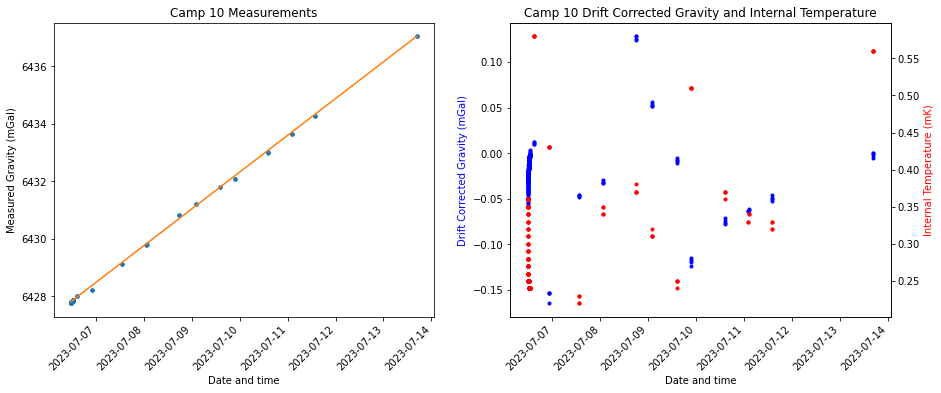

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(c10_all_data.timestamp, c10_all_data.tide_corr_grav, '.')
ax1.plot(c10_all_data.timestamp, c10_all_data.secs_elapsed*a +b)
ax2.plot(c10_all_data.timestamp, c10_all_data['linear_drift_corr'], 'b.', label='Linearally corrected data')
ax3=ax2.twinx()
ax3.plot(c10_all_data.timestamp, c10_all_data.temp, 'r.', label='Internal Temperature')
ax1.set_xlabel('Date and time', )
ax1.set_ylabel('Measured Gravity (mGal)')
ax2.set_xlabel('Date and time')
ax2.set_ylabel('Drift Corrected Gravity (mGal)', color='b')
ax3.set_ylabel('Internal Temperature (mK)', color='r')
ax1.set_title('Camp 10 Measurements')
ax2.set_title('Camp 10 Drift Corrected Gravity and Internal Temperature')
fig.autofmt_xdate(rotation=45)

Everything looks pretty good apart from the second measurements on on 2023-07-06 - this was at the end of day 1, going to look at the measurements through that day to check if can see evidence of a tare during the day. Doesn't seem to be much correlation between gravity and temperature.

On the continuous measurement once it has been drift corrected there is a stabilisation period of about 15-20 minutes. But the change during this time is only 0.02 mGal which is insignificant related to other errors.

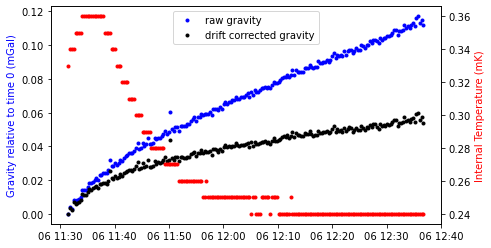

In [12]:
c10_contin['linear_drift_corr'] = c10_contin.tide_corr_grav - c10_contin.secs_elapsed*a + b
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(c10_contin.timestamp, c10_contin.tide_corr_grav - c10_contin.tide_corr_grav.iloc[0], 'b.', label ='raw gravity')
ax1.plot(c10_contin.timestamp, c10_contin.linear_drift_corr - c10_contin.linear_drift_corr.iloc[0], 'k.', label = 'drift corrected gravity')
ax2= ax1.twinx()
ax2.plot(c10_contin.timestamp, c10_contin.temp, 'r.')
ax1.set_ylabel('Gravity relative to time 0 (mGal)', color='b')
ax2.set_ylabel('Internal Temperature (mK)', color='r')
ax1.legend(loc='upper center')


## Day 1 Tare
Drift on day 1 looks abnormal - there might have been a tare during the day. We took 2 repeat measurements on day 1 - station 1 and station 7. Plotting the difference between these repeat measurements, and the difference at camp 10 at the start and end of the day. Plotting with and without drift correction. 

It looks like the tare probably occured between station 1 and station 1 repeat (the difference between 7 and 7 repeat is much smaller). That incorporates most of the day so it is hard to say when it occured. Question is whether to use linear drift correction as fitted to all data or do individual daily drift corrections. For now preceding with linear drift correction applied to all data.

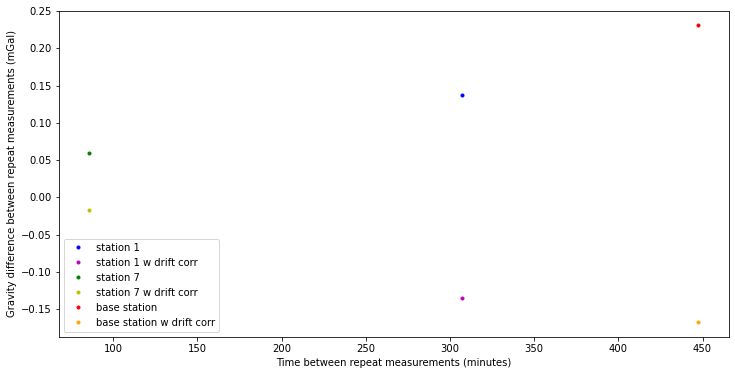

In [11]:
# drift on day 1 looks abnormal - plot whole days data to see if any more insight
fig, ( ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,6))
ax1.plot((repeat_sta_1.Datetime.iloc[1] - repeat_sta_1.Datetime.iloc[0])/pd.Timedelta(minutes=1), repeat_sta_1.grav_avg.iloc[1] - repeat_sta_1.grav_avg.iloc[0], 'b.', label='station 1')
ax1.plot((repeat_sta_1.Datetime.iloc[1] - repeat_sta_1.Datetime.iloc[0])/pd.Timedelta(minutes=1), repeat_sta_1.linear_drift_corr.iloc[1] - repeat_sta_1.linear_drift_corr.iloc[0], 'm.', label='station 1 w drift corr')

ax1.plot((repeat_sta_7.Datetime.iloc[1] - repeat_sta_7.Datetime.iloc[0])/pd.Timedelta(minutes=1), repeat_sta_7.grav_avg.iloc[1] - repeat_sta_7.grav_avg.iloc[0], 'g.', label='station 7')
ax1.plot((repeat_sta_7.Datetime.iloc[1] - repeat_sta_7.Datetime.iloc[0])/pd.Timedelta(minutes=1), repeat_sta_7.linear_drift_corr.iloc[1] - repeat_sta_7.linear_drift_corr.iloc[0], 'y.', label='station 7 w drift corr')

# ax1.plot(base1.Datetime, base1.linear_drift_corr, 'r.')
ax1.plot((base2.Datetime.iloc[0] - base1.Datetime.iloc[0])/pd.Timedelta(minutes=1), base2.grav_avg.iloc[0] - base1.grav_avg.iloc[0], 'r.', label='base station')
ax1.plot((base2.Datetime.iloc[0] - base1.Datetime.iloc[0])/pd.Timedelta(minutes=1), base2.linear_drift_corr.iloc[0] - base1.linear_drift_corr.iloc[0], '.', color='orange', label='base station w drift corr')

# ax1.plot(mins_elp, linear_corr, 'k', label='base station')

# ax2.plot(day1.timestamp, day1.temp, 'g.')

ax1.set_xlabel('Time between repeat measurements (minutes)')
ax1.set_ylabel('Gravity difference between repeat measurements (mGal)')
ax1.legend(loc='lower left')
# ax2.set_xlabel('Date and time')
# ax2.set_ylabel('Drift Corrected Gravity (mGal)', color='b')
# ax2.set_ylabel('Internal Temperature (mK)', color='r')

# ax1.set_xticks(ticks = day1.timestamp, labels = day1.sta)

In [12]:

stations = data_avgs.loc[(data_avgs['sta']<100) | (data_avgs['sta']>=200) | (data_avgs['sta']==102)].reset_index(drop=True) #stations all non base locations plus c10 at start of day 1 - part of profile 4
stations['linear_drift_corr'].iloc[0] = np.mean(c10_base.linear_drift_corr) #set c10 to be mean of all drift corrected measurements there
stations['grav_anom'] = stations['linear_drift_corr'] - np.mean(c10_base.linear_drift_corr) #make all measurements relative to mean at c10

/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_32822/130087068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['linear_drift_corr'].iloc[0] = np.mean(c10_base.linear_drift_corr) #set c10 to be mean of all drift corrected measurements there


### Latitude correction
Gravity changes with changing latitude so we need to correct for the changes in latitude during our survey. As we are just calculating gravity relative to camp 10 we will calculate a latitude correction based on the difference between the expected gravity at the stations on the glacier and the location at camp 10. Expected gravity is what the gravity would be at that latitude if the earth didn't have density and topography variations at the surface - its calculated from the international gravity formula.

In [13]:
stations['theo_grav_0'] =  9.7803267715*(1 + 0.0052790414*np.sin(np.deg2rad(stations.Lat))**2 
                                            + 0.0000232718*np.sin(2*np.deg2rad(stations.Lat))**4
                                            + 0.0000001262*np.sin(2*np.deg2rad(stations.Lat))**6
                                            + 0.0000000007*np.sin(2*np.deg2rad(stations.Lat))**8)*1e5


In [14]:
# Error on drift corrected data - root sum of squares combination of station and base standard deviations
#base std is the standard deviation of the C10 base station measurments after linear drift correction
base_std = np.std(c10_base.linear_drift_corr)
stations['drift_corr_grav_uc'] = np.sqrt(stations['grav_std']**2 + base_std**2)

### Free air anomaly
We need to correct for changes in during the gravity survey - again these are just compared to the camp 10 elevation

In [18]:
stations['fac'] = stations.Elev * 0.3086 #( R. E. Sheriff, Encyclopedic Dictionary of Exploration Geophysics, 2nd ed., (Society of Exploration Geophysicists, 1984), p. 141.)
stations['faa_error'] = np.sqrt((stations.Elev_std * -0.3086)**2 + (stations.drift_corr_grav_uc)**2)


### Bouguer anomaly
This is done as a simple slab correction with an additional component from the terrain correction.

In [19]:
stations['boug_slab_corr_2700'] = 2*np.pi*2700*stations.Elev*6.67e-11*1e5
stations['boug_slab_corr_2670'] = 2*np.pi*2670*stations.Elev*6.67e-11*1e5
stations['boug_slab_corr_2730'] = 2*np.pi*2730*stations.Elev*6.67e-11*1e5
stations['ba_error'] = np.sqrt((0.196*stations.Elev_std)**2  + (stations.drift_corr_grav_uc)**2)

In [20]:
terr_corr = pd.read_csv('Data/GPS/grav_all_ppk_stations_terr_corr_all.csv', usecols=[0, 11, 12, 13,14]) #read in the terrain correction

stations['terr_corr_2700'] = -999
stations['terr_corr_2670'] = -999
stations['terr_corr_2730'] = -999
stations['terr_corr_std'] = -999

for i in range(len(terr_corr)): #loop through all the stations in the gps data and apply terrain correction by station name
    stations['terr_corr_2700'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_2700'].iloc[i]
    stations['terr_corr_2670'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_2670'].iloc[i]
    stations['terr_corr_2730'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_2730'].iloc[i]
    stations['terr_corr_std'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_std'].iloc[i]
stations['ba_terr_error'] = np.sqrt((stations['terr_corr_std'])**2  + (stations.ba_error)**2)

/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_32822/1367643266.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['terr_corr_2700'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_2700'].iloc[i]
/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_32822/1367643266.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['terr_corr_2670'].iloc[stations.sta == terr_corr.sta.iloc[i]] = terr_corr['terr_corr_2670'].iloc[i]
/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_32822/1367643266.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [21]:
stations['fa_grav_theo'] = -stations['theo_grav_0'] + stations['fac']
stations['fa_grav_theo_rel'] = stations['fa_grav_theo'] - stations['fa_grav_theo'].iloc[0]
stations['fa_anom'] = stations['grav_anom'] + stations['fa_grav_theo_rel']

stations['grav_theo_2670'] = -stations['theo_grav_0'] + stations['fac'] - stations['boug_slab_corr_2670'] + stations['terr_corr_2670']
stations['grav_theo_rel'] = stations['grav_theo_2670'] - stations['grav_theo_2670'].iloc[0]
stations['boug_anom_2670'] = stations['grav_anom'] + stations['grav_theo_rel']

stations['grav_theo_2700'] = -stations['theo_grav_0'] + stations['fac'] - stations['boug_slab_corr_2700'] + stations['terr_corr_2700']
stations['grav_theo_rel'] = stations['grav_theo_2700'] - stations['grav_theo_2700'].iloc[0]
stations['boug_anom_2700'] = stations['grav_anom'] + stations['grav_theo_rel']

stations['grav_theo_2730'] = -stations['theo_grav_0'] + stations['fac'] - stations['boug_slab_corr_2730'] + stations['terr_corr_2730']
stations['grav_theo_rel'] = stations['grav_theo_2730'] - stations['grav_theo_2730'].iloc[0]
stations['boug_anom_2730'] = stations['grav_anom'] + stations['grav_theo_rel']

### Repeat measurements - error estimation and averaging

In [22]:
# repeat measurments differences
rep_meas = [1, 11, 7, 71, 4, 21, 210, 212, 305, 409, 403, 408]

#for sum of errors skip 1 and 11 because they are anomalously high -- need to look at that day again
sq_sum = 0
for i in range(6,len(rep_meas),2):
    diff = (stations['boug_anom_2700'][stations['sta']==rep_meas[i]].values - stations['boug_anom_2700'][stations['sta']==rep_meas[i+1]].values)
    print(rep_meas[i], diff)
    sq_sum = sq_sum + (stations['boug_anom_2700'][stations['sta']==rep_meas[i]].values - stations['boug_anom_2700'][stations['sta']==rep_meas[i+1]].values)**2
rep_meas_avg = np.sqrt(sq_sum)[0]
stations['rep_error_oth'] = rep_meas_avg

#Since repeat measurements error is higher from day 1 - will use average of day 1 repeats for uncertainty on those measurements
sq_sum = 0
for i in range(0,6,2):
    diff = (stations['boug_anom_2700'][stations['sta']==rep_meas[i]].values - stations['boug_anom_2700'][stations['sta']==rep_meas[i+1]].values)
    print(rep_meas[i], diff)
    sq_sum = sq_sum + (stations['boug_anom_2700'][stations['sta']==rep_meas[i]].values - stations['boug_anom_2700'][stations['sta']==rep_meas[i+1]].values)**2
rep_meas_avg = np.sqrt(sq_sum)[0]
stations['rep_error_day1'] = rep_meas_avg

diff_max = stations['boug_anom_2700'][stations['sta']==rep_meas[0]].values - stations['boug_anom_2700'][stations['sta']==rep_meas[1]].values
stations['rep_error_max'] = diff_max[0]
data_rep_avg = stations.copy()
for i in range(0,len(rep_meas),2):
    # data_rep_avg['faa'][data_rep_avg['sta']==rep_meas[i]] =  (data_rep_avg['faa'][data_rep_avg['sta']==rep_meas[i]].values + data_rep_avg['faa'][data_rep_avg['sta']==rep_meas[i+1]].values)/2
    data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i]] =  (data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i]].values + data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i+1]].values)/2
    data_rep_avg = data_rep_avg.drop(index = data_rep_avg[data_rep_avg['sta']==rep_meas[i+1]].index)
    

print ('The average free air anomaly error based on repeat measurements is: ' + str(rep_meas_avg))
print ('The average free air anomaly error based on sum of uncertainties is: ' + str(np.mean(stations.ba_error)))
print ('The max free air anomaly error based on sum of uncertainties is: ' + str(max(stations.ba_error)))


210 [0.02278932]
305 [-0.02638006]
403 [-0.05223159]
1 [0.15461441]
7 [0.01702676]
4 [-0.04514182]
The average free air anomaly error based on repeat measurements is: 0.16196700210968104
The average free air anomaly error based on sum of uncertainties is: 0.06956098866309293
The max free air anomaly error based on sum of uncertainties is: 0.07068840492094715


/var/folders/6g/r2y8czh94x50dtz0hyff18nr0000gq/T/ipykernel_32822/3133432602.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i]] =  (data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i]].values + data_rep_avg['boug_anom_2700'][data_rep_avg['sta']==rep_meas[i+1]].values)/2


In [23]:
#rss the measurement error to the repeat meas error

data_rep_avg['error'] = np.sqrt(data_rep_avg['rep_error_max']**2 + data_rep_avg['ba_terr_error']**2)

In [31]:
np.mean(data_rep_avg['ba_terr_error'])

0.08037398806910145

In [24]:
np.mean(data_rep_avg['error'])

0.17443967905503494

### Plot the data

Text(0, 0.5, 'Northing (m)')

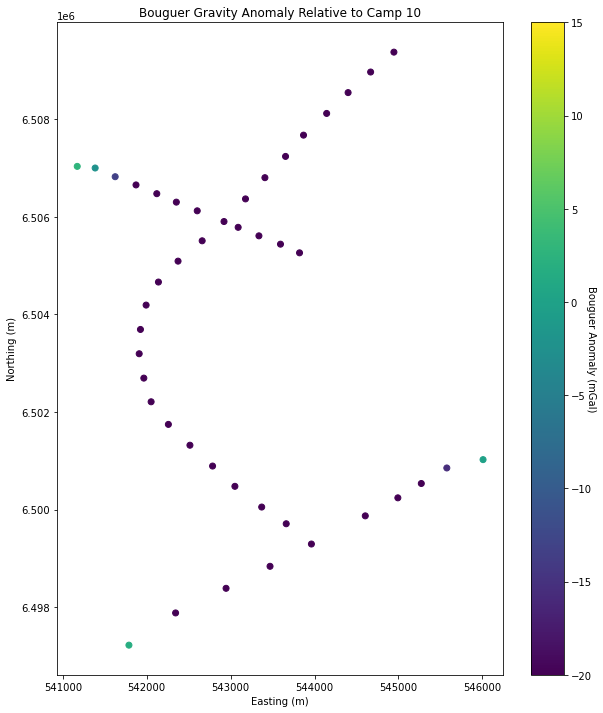

In [86]:
plt.figure(figsize=(10,12))
plt.scatter(data_rep_avg.x_8N, data_rep_avg.y_8N, c=data_rep_avg.boug_anom_2700, vmin=-20, vmax=15)#, vmin=min(stations.boug_anom), vmax=-30) #you can uncomment these to vary the min and max color values
plt.title('Bouguer Gravity Anomaly Relative to Camp 10')
cbar = plt.colorbar()
cbar.set_label('Bouguer Anomaly (mGal)', rotation=270)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

In [145]:
# data_avgs_export = data_rep_avg.drop(columns=['secs_elapsed',	'linear_drift_corr', 'theo_grav_0','fac', 'terr_corr',	'boug_slab_corr', 'fa_grav_theo',
#        'fa_grav_theo_rel', 'grav_theo', 'grav_theo_rel'])
data_rep_avg.to_csv('Data/grav_faa_ba_update0516.csv', index=False)

In [136]:
np.mean(data_rep_avg['ba_terr_error'])

0.08037398806910145